# 1. Establish the network

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TerminateOnNaN
from util import EvaluateAccuracy
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import cv2
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(2048,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)

# Load some weights into the model.
weights_path = 'weights/siamese_net_epoch-136_loss-0.0125_val_loss-0.0918.h5'
siamese_net.load_weights(weights_path, by_name=True)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

Using TensorFlow backend.
/home/jerry/anaconda2/envs/tf35/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


20073281

# 2. Load test images

531.2252964426877 531.2252964426877


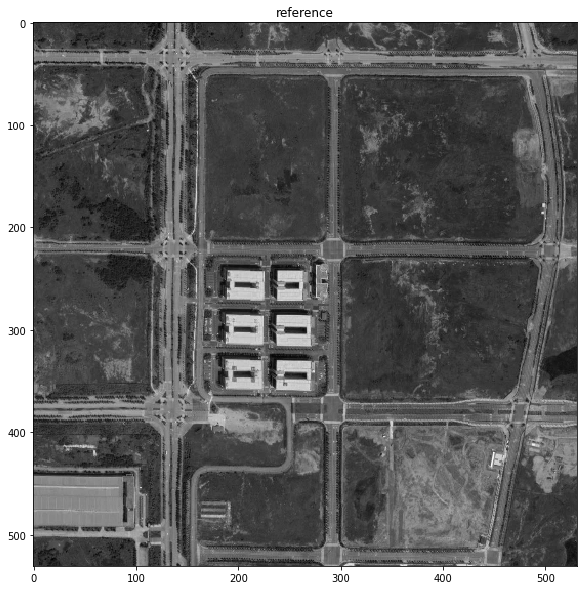

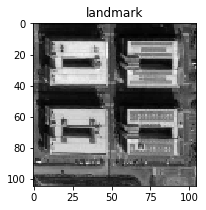

In [39]:
#load reference image
ref_image = cv2.imread('test/181122205344_L17/google_181122205344.png', cv2.IMREAD_GRAYSCALE)
ref_height, ref_width = ref_image.shape

#load match image
mark_image = cv2.imread('test/181122205344_L17/landmark.png', cv2.IMREAD_GRAYSCALE)
mark_height, mark_width = mark_image.shape
#resize the image to match the network input
resized_mark = cv2.resize(mark_image, (105, 105))
resize_rate = (105/float(mark_height), 105/float(mark_width))
ref_size = (int(ref_width*resize_rate[1]), int(ref_height*resize_rate[0]))
resized_ref = cv2.resize(ref_image, ref_size)
print(ref_height*resize_rate[0], ref_width*resize_rate[1])
#show the images
plt.figure('reference',figsize=(10,10))
plt.title('reference')
plt.imshow(resized_ref, cmap='gray')
plt.figure("landmark", figsize=(3,3))
plt.title('landmark')
plt.imshow(resized_mark, cmap='gray')

# Start matching process

In [40]:
#set the step size
step = [5, 5]
#numbers of pairs per batch
batchsize = 128
#initialize a numpy array to store scores
scores = np.zeros(((resized_ref.shape[0]-105)//step[0]+1, (resized_ref.shape[1]-105)//step[1]+1))
pair_num = scores.shape[0]*scores.shape[1]
best_score = 0
best_location = (0, 0)
batch_cnt = 0
cnt = 0
pair_list = []
location_list = []
for i in range(0, resized_ref.shape[0]-105, step[0]):
    for j in range(0, resized_ref.shape[1]-105, step[1]):
        #make a batch pairs
        if batch_cnt < batchsize:
            ref_patch = resized_ref[i:i+105, j:j+105]
            #print([i,j])
            pair_list.append(ref_patch)
            location_list.append((j,i))
            batch_cnt += 1
            cnt += 1
            continue
        pairs = [np.concatenate([resized_mark,]*batchsize, axis=0).reshape(batchsize,105,105,1), 
                 np.concatenate(pair_list, axis=0).reshape(batchsize,105,105,1)]
        probs = siamese_net.predict(pairs)
        print("score for %d/%d pair: %f"%(cnt, pair_num, probs[-1]))
        for k, prob in enumerate(probs):
            if prob > best_score:
                best_score = prob
                best_location = location_list[k]
        batch_cnt = 0
        location_list = []
        pair_list = []
            
print('best score is: %f'%best_score)
print(best_location)
        
        


score for 128/7396 pair: 0.004657
score for 256/7396 pair: 0.000003
score for 384/7396 pair: 0.045802
score for 512/7396 pair: 0.000057
score for 640/7396 pair: 0.000192
score for 768/7396 pair: 0.000002
score for 896/7396 pair: 0.000091
score for 1024/7396 pair: 0.000001
score for 1152/7396 pair: 0.000106
score for 1280/7396 pair: 0.000000
score for 1408/7396 pair: 0.000035
score for 1536/7396 pair: 0.000000
score for 1664/7396 pair: 0.000001
score for 1792/7396 pair: 0.000001
score for 1920/7396 pair: 0.000289
score for 2048/7396 pair: 0.000007
score for 2176/7396 pair: 0.000058
score for 2304/7396 pair: 0.000025
score for 2432/7396 pair: 0.002060
score for 2560/7396 pair: 0.006055
score for 2688/7396 pair: 0.000023
score for 2816/7396 pair: 0.000104
score for 2944/7396 pair: 0.000000
score for 3072/7396 pair: 0.000000
score for 3200/7396 pair: 0.000010
score for 3328/7396 pair: 0.002373
score for 3456/7396 pair: 0.000000
score for 3584/7396 pair: 0.000070
score for 3712/7396 pair: 0

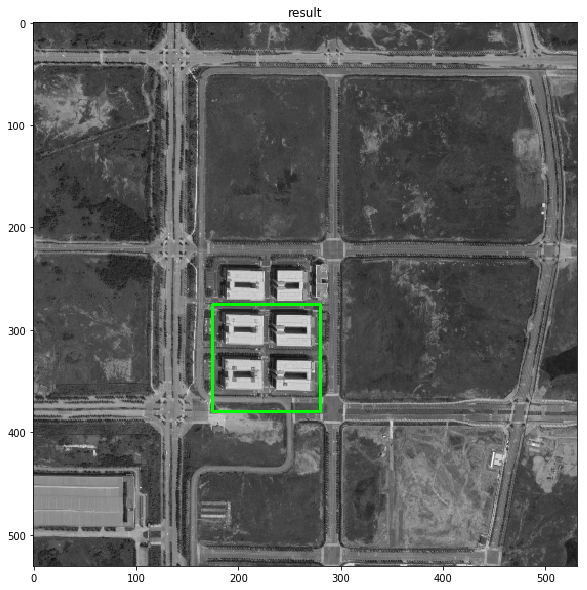

In [41]:
#concatenate to make a 3-channel image
show_ref = np.concatenate([resized_ref[:,:,np.newaxis],]*3, axis=-1)
result = cv2.rectangle(show_ref, best_location, (best_location[0]+105,best_location[1]+105), (0,255,0), thickness=2)
plt.figure('result',figsize=(10,10))
plt.title('result')
plt.imshow(result)
